Using device: mps


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading and transforming images...
Encoding images to latent representations...
Interpolating between latents...


Interpolating Latents:   0%|          | 0/5 [00:00<?, ?it/s]

Interpolating step 1/5...
Interpolating step 2/5...
Interpolating step 3/5...
Interpolating step 4/5...
Interpolating step 5/5...
Plotting results...


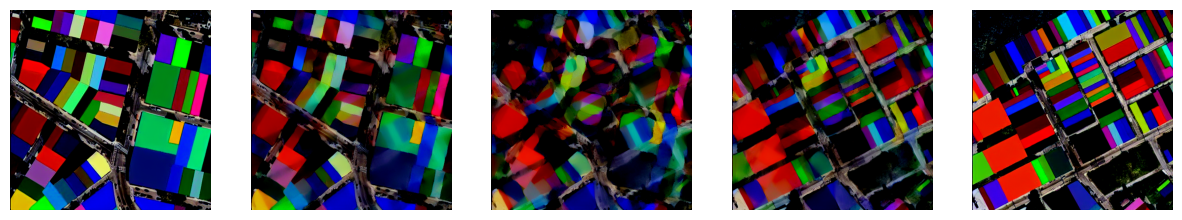

In [1]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from diffusers import StableDiffusionPipeline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

# Set device to MPS if available, otherwise fall back to CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

try:
    # Load the pre-trained Stable Diffusion model
    model_id = "runwayml/stable-diffusion-v1-5" 
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16 if device.type == "cuda" else torch.float32)
    pipe = pipe.to(device)
    
    # Enable attention slicing to reduce memory usage
    pipe.enable_attention_slicing()

    # Define transformations for input images
    transform = Compose([
        Resize((512, 512)),  # Standard size for Stable Diffusion
        ToTensor(),
        Normalize([0.5], [0.5])
    ])

    # Function to load and transform images
    def load_image(image_path):
        image = Image.open(image_path).convert("RGB")
        return transform(image).unsqueeze(0).to(device)

    # Load images (update these paths)
    image1_path = "../data/ma-boston/parcels/parcels_50.jpg" 
    image2_path = "../data/pa-pittsburgh/parcels/parcels_263.jpg"

    print("Loading and transforming images...")
    image1 = load_image(image1_path)
    image2 = load_image(image2_path)

    # Encode images to latents
    print("Encoding images to latent representations...")
    with torch.no_grad():
        latents1 = pipe.vae.encode(image1).latent_dist.sample()
        latents2 = pipe.vae.encode(image2).latent_dist.sample()

    # Interpolate between latents
    print("Interpolating between latents...")
    num_steps = 5
    alphas = np.linspace(0, 1, num_steps)
    interpolated_images = []
    
    # Initialize the progress bar
    progress_bar = tqdm(total=num_steps, desc="Interpolating Latents")

    for idx, alpha in enumerate(alphas):
        print(f"Interpolating step {idx + 1}/{num_steps}...")
        interpolated_latent = (1 - alpha) * latents1 + alpha * latents2
        with torch.no_grad():
            decoded_image = pipe.vae.decode(interpolated_latent).sample[0]
        interpolated_images.append(decoded_image)
        
        # Update the progress bar
        progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

    # Plot results
    print("Plotting results...")
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
    for ax, img in zip(axes, interpolated_images):
        ax.imshow(img.permute(1, 2, 0).cpu().numpy().clip(0, 1))
        ax.axis('off')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")